# Simulated Mobile Health Data and Anomaly Detection Example
This notebook is intended to combine and provide examples of elements of the simulation and anomaly detection pipeline.

In [1]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [2]:
import pandas as pd
from mhealth_anomaly_detection import load_refs as lr
from mhealth_anomaly_detection import simulate_daily as sd
from mhealth_anomaly_detection import anomaly_detection as ad
from mhealth_anomaly_detection import plots

/Users/sakre/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simulate data with weekly anomalies

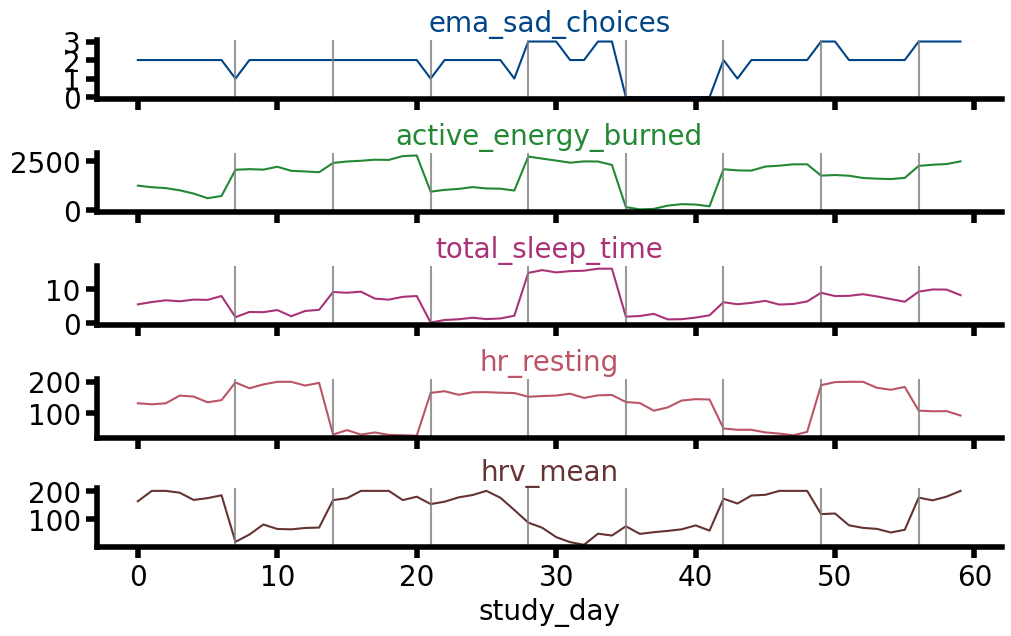

In [22]:
# Feature parameters for simulation
palette = lr.get_colors('../lib/colors.json')
all_feature_params = lr.get_all_feature_params('../lib/feature_parameters.json')
sim_type = 'weeklyAnomaly'
feature_params = all_feature_params[sim_type]

anomaly_days = [7, 14, 21, 28, 35, 42, 49, 56]
# Simulate daily data with weekly anomalies
# Frequency and scale of anomalies set in lib/feature_parameters.json
simulator = sd.RandomAnomalySimulator(
    feature_params=feature_params,
    n_days=60,
    n_subjects=2,
    sim_type=sim_type,
    cache_simulation=False,
)
simulated_data = simulator.simulateData()

# Get 1 subject and plot their data over time
subject_data: pd.DataFrame = simulated_data[
    simulated_data.subject_id == simulated_data.subject_id.unique()[1]
]
fig, axes = plots.lineplot_features(
    subject_data.copy(),
    [
        'ema_sad_choices',
        *feature_params.keys()
    ],
    palette=palette,
)
for ax in axes.flatten():
    ylims = ax.get_ylim()
    ax.vlines(anomaly_days, *ylims, color='gray', alpha=.8 )
    ax.set_ylim(*ylims)

## Anomaly Detection

### Simple 3-component PCA based

/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_92421/3391179516.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_data['anomaly'] = anomalyDetector.labelAnomaly(subject_data)
/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_92421/3391179516.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_data['total_re'] = reconstruction_error['total_re'].fillna(0)


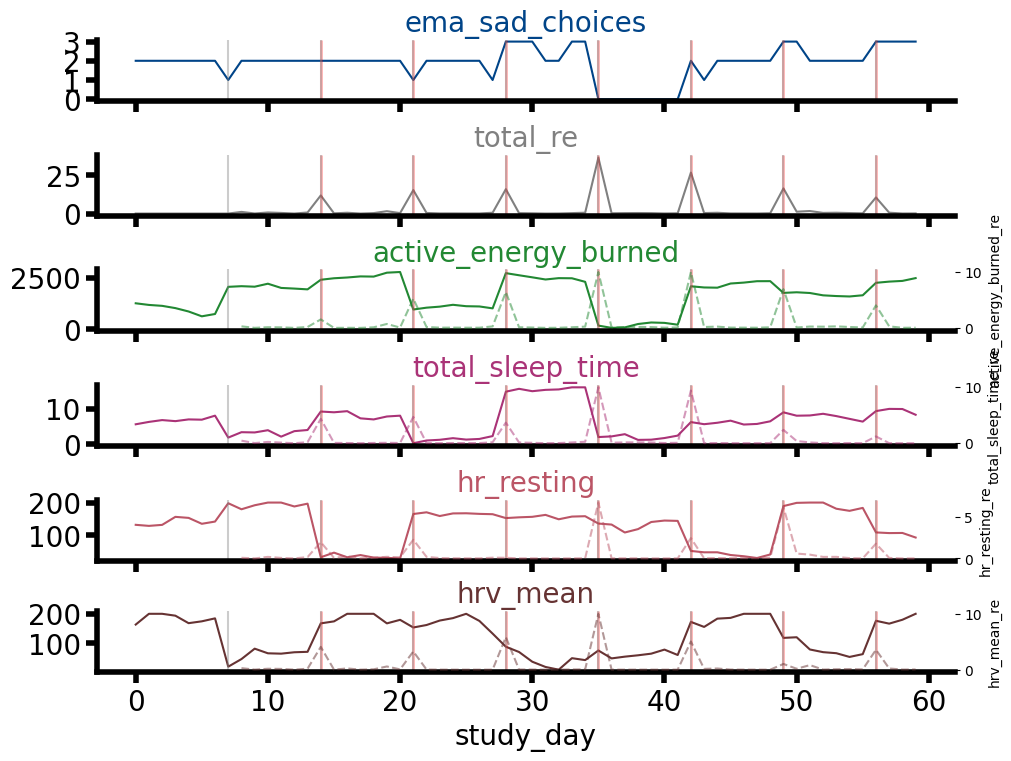

In [93]:
importlib.reload(ad)
importlib.reload(plots)

features = list(feature_params.keys())
# Rolling 7 day PCA based anomaly detection
anomalyDetector = ad.PCARollingAnomalyDetector(
    features=features,
    window_size=7,
    max_missing_days=2,
    remove_past_anomalies=False
)

# Get reconstruction error and use to do anomaly labeling
reconstruction_error = anomalyDetector.getReconstructionError(subject_data)
subject_data['anomaly'] = anomalyDetector.labelAnomaly(subject_data)
subject_data['total_re'] = reconstruction_error['total_re'].fillna(0)

# Plot features with anomalies labeled
palette = lr.get_colors('../lib/colors.json')
fig, axes = plots.lineplot_features(
    subject_data,
    [
        'ema_sad_choices',
        'total_re',
        *features
    ],
    palette=palette,
    anomaly_col='anomaly'
)
for ax in axes.flatten():
    ylims = ax.get_ylim()
    ax.vlines(anomaly_days, *ylims, color='gray', alpha=.4 )
    ax.set_ylim(*ylims)

plots.overlay_reconstruction_error(
    reconstruction_error,
    fig,
    axes,
    [
        'ema_sad_choices',
        'total_re',
        *features
    ],
    palette=palette,

)

<Axes: xlabel='study_day', ylabel='component-feature'>

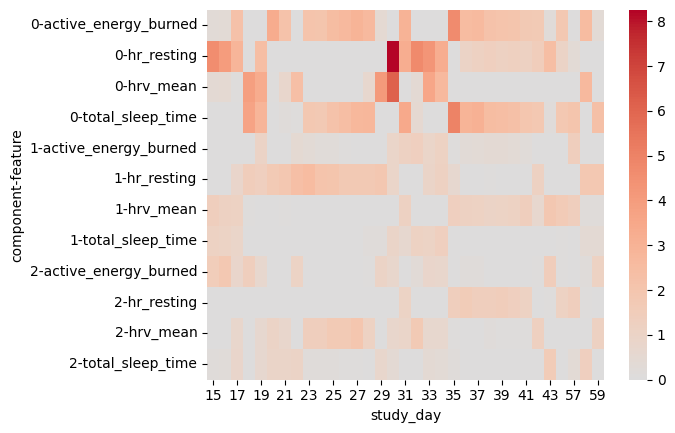

In [92]:
import numpy as np
import seaborn as sns

c = anomalyDetector.components
feature_map = {
    i: f for i, f in enumerate(features)
}
indices = np.array(list(np.ndindex(c.shape)))

df = pd.DataFrame({
    'study_day': indices[:, 0],
    'component': indices[:, 1],
    'feature': indices[:, 2],
    'weight': c.flatten()
})
df['feature'] = df.feature.map(feature_map)
sns.heatmap(df.pivot_table(
    index=['component', 'feature'],
    columns='study_day',
    values='weight'
),cmap='coolwarm', center=0)

## Non-negative Matrix Factorization Rolling Anomaly Detection

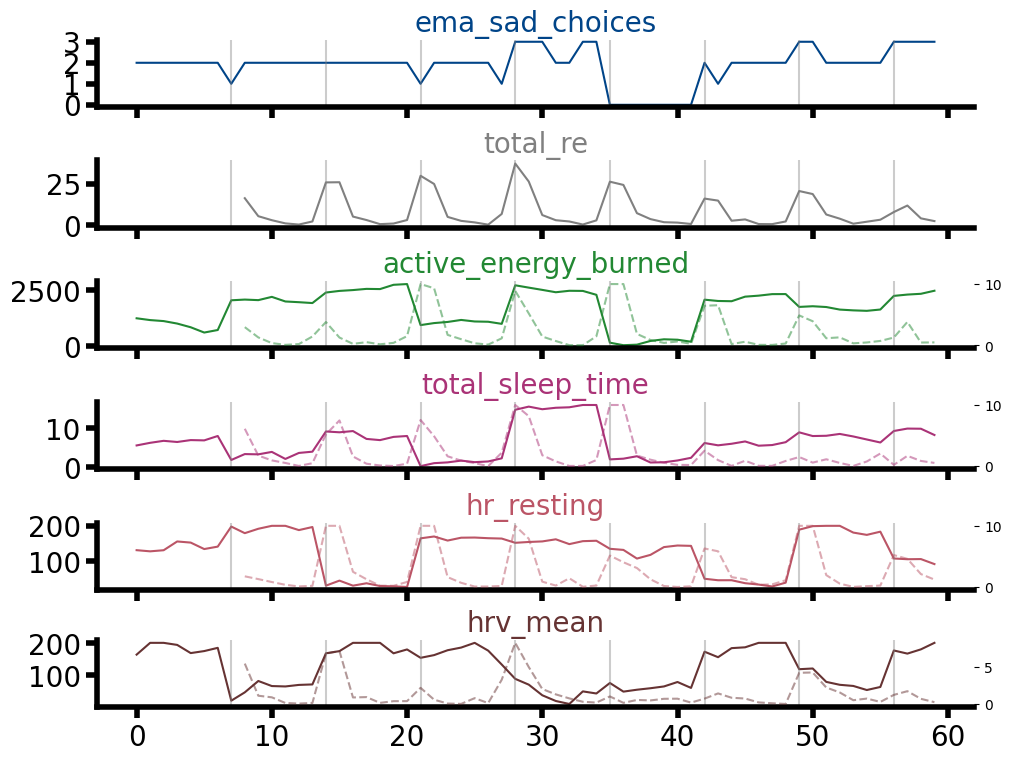

In [8]:
importlib.reload(ad)
importlib.reload(plots)

features = list(feature_params.keys())
# Rolling 7 day NMF based anomaly detection
anomalyDetector = ad.NMFRollingAnomalyDetector(
    features=features,
    window_size=7,
    max_missing_days=2,
)

# Get reconstruction error and use to do anomaly labeling
reconstruction_error = anomalyDetector.getReconstructionError(subject_data)
subject_data['anomaly'] = anomalyDetector.labelAnomaly(subject_data)
subject_data['total_re'] = reconstruction_error['total_re']

# Plot features with anomalies labeled
palette = lr.get_colors('../lib/colors.json')
fig, axes = plots.lineplot_features(
    subject_data,
    [
        'ema_sad_choices',
        'total_re',
        *features
    ],
    palette=palette,
    anomaly_col='anomaly'
)

for ax in axes.flatten():
    ylims = ax.get_ylim()
    ax.vlines(anomaly_days, *ylims, color='gray', alpha=.4 )
    ax.set_ylim(*ylims)
plots.overlay_reconstruction_error(
    reconstruction_error,
    fig,
    axes,
    [
        'ema_sad_choices',
        'total_re',
        *features
    ],
    palette=palette,

);

<AxesSubplot: xlabel='study_day', ylabel='component-feature'>

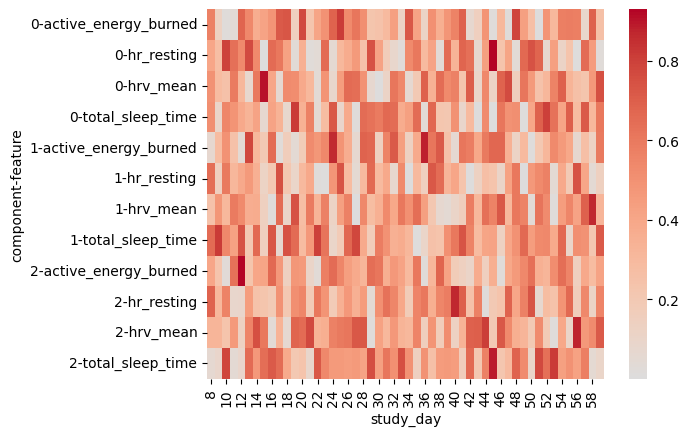

In [9]:
import numpy as np
import seaborn as sns

c = anomalyDetector.components
feature_map = {
    i: f for i, f in enumerate(features)
}
indices = np.array(list(np.ndindex(c.shape)))

df = pd.DataFrame({
    'study_day': indices[:, 0],
    'component': indices[:, 2],
    'feature': indices[:, 1],
    'weight': c.flatten()
})
df['feature'] = df.feature.map(feature_map)
sns.heatmap(df.pivot_table(
    index=['component', 'feature'],
    columns='study_day',
    values='weight'
),cmap='coolwarm', center=0)

## Rolling Mean based anomaly detection

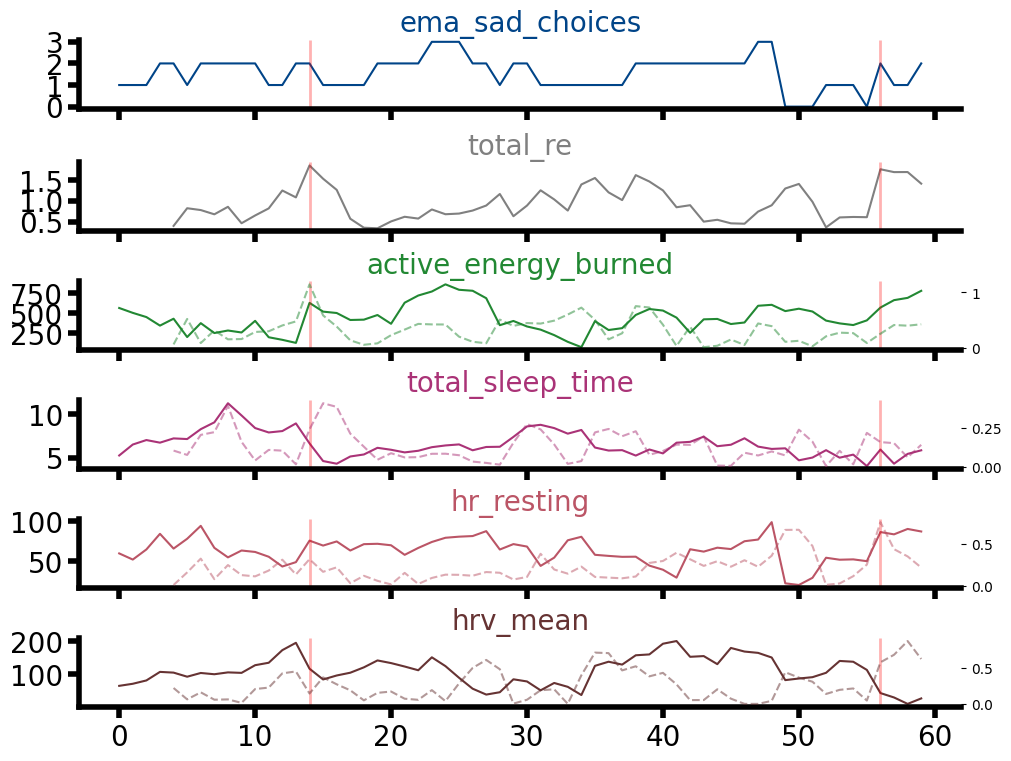

In [49]:
importlib.reload(ad)

# Rolling 7 day rolling mean based anomaly detection
anomalyDetector = ad.BaseRollingAnomalyDetector(
    features=feature_params.keys(),
    window_size=7,
    max_missing_days=2,
)

# Get reconstruction error and use to do anomaly labeling
reconstruction_error = anomalyDetector.getReconstructionError(subject_data)
subject_data['anomaly'] = anomalyDetector.labelAnomaly(reconstruction_error)
subject_data['total_re'] = reconstruction_error['total_re']

# Plot features with anomalies labeled
palette = lr.get_colors('../lib/colors.json')
fig, axes = plots.lineplot_features(
    subject_data,
    [
        'ema_sad_choices',
        'total_re',
        *feature_params.keys()
    ],
    palette=palette,
    anomaly_col='anomaly'
)

plots.overlay_reconstruction_error(
    reconstruction_error,
    fig,
    axes,
    [
        'ema_sad_choices',
        'total_re',
        *feature_params.keys()
    ],
    palette=palette,

);